In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as pp
import numpy as np
from ipywidgets import interact, IntSlider, fixed

from sigma_graph.envs.figure8.action_lookup import MOVE_LOOKUP, TURN_90_LOOKUP
from sigma_graph.envs.figure8.default_setup import OBS_TOKEN
from sigma_graph.envs.figure8.figure8_squad_rllib import Figure8SquadRLLib
from sigma_graph.envs.figure8.gflow_figure8_squad import GlowFigure8Squad
#from graph_scout.envs.base import ScoutMissionStdRLLib
import sigma_graph.envs.figure8.default_setup as default_setup
from sigma_graph.data.file_manager import check_dir, find_file_in_dir, load_graph_files
import model  # THIS NEEDS TO BE HERE IN ORDER TO RUN __init__.py!
import model.utils as utils
import model.gnn_gflow 
from trajectory import Trajectory
import losses

import torch.optim as optim
import wandb
import json
import random
import networkx as nx
import matplotlib.pyplot as plt

NUM_EPOCHS = 1000
# default = 34
BATCH_SIZE = 50
LEARNING_RATE = 3e-4
WANDB = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

local_action_move = {
    0: "NOOP",
    1: "N",
    2: "S",
    3: "W",
    4: "E",
}

def state_to_vec(state):
    result = [0]*27
    result[state-1] = 1
    return torch.tensor(result).float()

def compute_reward(state):
    if state == 10:
        return 2
    if state == 2:
        return 1
    return 0

def convert_discrete_action_to_multidiscrete(action):
        return [action % len(local_action_move), action // len(local_action_move)]

2024-05-02 13:57:42,832	WARNING deprecation.py:47 -- DeprecationWarning: `ray.rllib.agents.dqn` has been deprecated. Use `ray.rllib.algorithms.[dqn|simple_q|r2d2|apex_dqn]` instead. This will raise an error in the future!


In [2]:
# Investigate loss rewar mirror
# Try real reward
# Make code cleaner 
# visualize flows 

config = {
    "custom_model_config": {
        "custom_model": "fcn", #fcn #attn_fcn
        "reward": "single", #random_region random single complex
        "reward_interval": "step", #trajectory 
        "trajectory_per_reward": 1,
        "embedding": "coordinate", #number #coordinate
        "is_dynamic_embedding": False,
        "trajectory_length": 34,
        "nred": 1,
        "nblue": 1,
        "start_node": 22,
        "aggregation_fn": "agent_node",
        "hidden_size": 15,
        "is_hybrid": False,
        "conv_type": "gcn",
        "layernorm": False,
        "graph_obs_token": {"embed_opt": False, "embed_dir": True},
    },
    "env_config": {
        "env_path": ".",
        "act_masked": True,
        "init_red": None,
        "init_blue": None,
        "init_health_red": 20,
        "init_health_blue": 20,
        "obs_embed": False,
        "obs_dir": False,
        "obs_team": True,
        "obs_sight": False,
        "log_on": True,
        "log_path": "logs/temp/",
        "fixed_start": -1,
        "penalty_stay": 0,
        "threshold_damage_2_blue": 2,
        "threshold_damage_2_red": 5,
    },
}

current_time = datetime.now()
run_name = f"{config['custom_model_config']['custom_model']}-{config['custom_model_config']['reward']}-{config['custom_model_config']['embedding']}-{current_time.strftime('%Y-%m-%d %H:%M:%S')}"
print(run_name)

if WANDB:
    wandb.init(
        project="graph-training-simulation",
        config={
                "model_config": config,
                "exp_config": {
                    "learning_rate": LEARNING_RATE,
                    "epocs": NUM_EPOCHS,
                    "batch_size": BATCH_SIZE
            }
        },
        name=run_name
    )

gflowfigure8 = GlowFigure8Squad(sampler_config=config)
optimizer = optim.AdamW(gflowfigure8.sampler.parameters(), lr=LEARNING_RATE)

fcn-single-coordinate-2024-05-02 13:57:43
data_pat /home/rmarr/Documents/GflowsForSimulation_env/GflowsForSimulation/sigma_graph/data/parsed/info_list_pat_0_27.pickle


In [3]:
minibatch_loss = 0
minibatch_reward = 0
minibatch_z = 0
minibatch_pf = 0
minibatch_pb = 0

pbar = tqdm(total=NUM_EPOCHS)
episode = 0

while episode <= NUM_EPOCHS:
  
  TEMP_AGENT_INDEX = 0
  gflowfigure8._reset_agents()
  
  total_P_F = 0
  total_P_B = 0
  total_reward = 0

  region_nodes = {15, 11, 10}

  if config['custom_model_config']['reward'] == 'random':
    reward_node = [random.randint(1, 27)]
  elif config['custom_model_config']['reward'] == 'random_region':
    reward_node = random.sample(region_nodes, 1)
  elif config['custom_model_config']['reward'] == 'single':
    reward_node = [17]
  elif config['custom_model_config']['reward'] == 'complex':
    reward_node = []
  
  if config['custom_model_config']['is_dynamic_embedding']:  
    gflowfigure8.update_reward(reward_node)
    
  gflowfigure8.reset()

  no_trajectory = config['custom_model_config']['trajectory_per_reward']
  trajectory_length = config['custom_model_config']['trajectory_length']

  for trajectory in range(no_trajectory):
    trajectory_path = []
    action_path = []
    for t in range(trajectory_length):
      step = gflowfigure8.step(TEMP_AGENT_INDEX, reward_node)  
      total_P_F += step['forward_prob']
      total_P_B += step['backward_prob']
      total_reward += step['step_reward']
      trajectory_path.append(step['red_node'])
      action_path.append(step['action'])

    logZ = gflowfigure8.sampler.logZ
    
    if config['custom_model_config']['reward'] == 'complex':
      episode_reward = gflowfigure8._episode_rewards_aggressive()[0]
      total_reward += episode_reward
      
    clipped_reward = torch.log(torch.tensor(total_reward)).clip(-20)

    # clipped_reward = torch.log(torch.tensor(end_rewards)).clip(-20)

    loss = (logZ + total_P_F - clipped_reward - total_P_B).pow(2)

    minibatch_loss += loss
    minibatch_reward += clipped_reward
    minibatch_z += logZ
    minibatch_pf += total_P_F
    minibatch_pb += total_P_B

    if (episode + 1) % BATCH_SIZE == 0:
      if WANDB:
        wandb.log({
            "loss": minibatch_loss/BATCH_SIZE, 
            "reward":  minibatch_reward/BATCH_SIZE,
            "pf": minibatch_pf/BATCH_SIZE,
            "pb": minibatch_pb/BATCH_SIZE,
            "z": minibatch_z/BATCH_SIZE
          })
        # for name, param in sampler.named_parameters():
        #     wandb.log({f"{name}_mean": param.data.mean().item(), f"{name}_std": param.data.std().item()})
      
      minibatch_loss.backward(retain_graph=True)
      optimizer.step()
      optimizer.zero_grad()
      minibatch_loss = 0
      minibatch_reward = 0
      minibatch_z = 0 
      minibatch_pf = 0 
      minibatch_pb = 0 

    pbar.update(1)
    episode = episode + 1

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 149/100000 [00:11<1:50:28, 15.06it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(gflowfigure8, f'models/{run_name}.pt')

In [ ]:
gflowfigure8.reset()
red_path = []
blue_path = []
total_reward = 0
for r in range(34):   
    step = gflowfigure8.step(0, [])
    red_path.append(step['red_node'])
    blue_path.append(step['blue_node'])
    total_reward += step['step_reward']

print(f'step_rewards {total_reward}')
episode_reward = gflowfigure8._episode_rewards_aggressive()[0]
print(f'episode_reward {episode_reward}')
total_reward += episode_reward
print(f'total_reward {total_reward}')

step_rewards 12
episode_reward 4
total_reward 16


In [ ]:
map_info, _ = load_graph_files(map_lookup="S")
col_map = ["gold"] * len(map_info.n_info)

def display_graph(index):
    fig, ax = plt.subplots(figsize=(8, 6))
    cur_col_map = col_map[:]
    cur_col_map[red_path[index]-1] = "red"
    cur_col_map[blue_path[index]-1] = "blue"
    nx.draw_networkx(map_info.g_acs, pos=map_info.n_info, node_color=cur_col_map, edge_color="blue", arrows=True, ax=ax)
    ax.set_title(f"Graph {index}")
    plt.axis('off')
    plt.show()

# Create an interactive widget to display different graphs
slider = IntSlider(min=0, max=33, step=1, value=0, description='Graph Index')
interact(display_graph, index=slider)

data_pat /home/rmarr/Documents/GflowsForSimulation_env/GflowsForSimulation/sigma_graph/data/parsed/info_list_pat_0_27.pickle


interactive(children=(IntSlider(value=0, description='Graph Index', max=33), Output()), _dom_classes=('widget-…

<function __main__.display_graph(index)>

{0: {'NOOP': -60.4727771107851, 'N': 106.27830927735266, 'S': 242.67455391701216, 'W': -21.35154864633226, 'E': -106.26484738761201}, 1: {'NOOP': -60.62052341163985, 'N': 106.51415441047577, 'S': 243.20142030698946, 'W': -21.377637016729825, 'E': -106.51581788033972}, 2: {'NOOP': -60.884469958495, 'N': 106.26572812061877, 'S': 242.2664891177544, 'W': -20.679572532407548, 'E': -106.7256073645218}, 3: {'NOOP': -61.26943022359417, 'N': 106.22777940943796, 'S': 241.81157183297717, 'W': -20.022116900628873, 'E': -107.14712186935677}, 4: {'NOOP': -61.47521817445265, 'N': 106.47863574458235, 'S': 242.32792696759202, 'W': -19.972130412177375, 'E': -107.46903035471004}, 5: {'NOOP': -61.65480289514416, 'N': 106.14886286625207, 'S': 241.24151965554037, 'W': -19.318452165137728, 'E': -107.55450986421928}, 6: {'NOOP': -61.99729756402821, 'N': 106.14041056775649, 'S': 240.9076854935018, 'W': -18.761662649227198, 'E': -107.93854180451586}, 7: {'NOOP': -62.21665800941746, 'N': 106.38346676412178, 'S':

IndexError: list index out of range

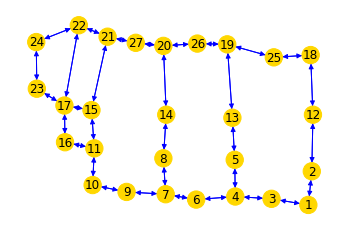

In [ ]:
# TODO: there has to be a better way to do this
def norm_dict(unnorm):
    min_val = 9999999
    for key in unnorm:
        min_val = min(unnorm[key], min_val)
    for key in unnorm:
        unnorm[key] = unnorm[key] + (min(min_val, 0) * -1)
    sum = 0
    for key in unnorm:
        sum += unnorm[key]
    for key in unnorm:
        unnorm[key] /= sum
        
gflowfigure8._reset_agents()
state_dirs = {}
for node in range(27):
    states = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    states[0][node] = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(np.array([states[0],], dtype=np.int8)).to(device)
    probs = gflowfigure8.sampler.forward(state, 1)
    # (forward_prob, action) = gflowfigure8.probs_to_action(probs)
    total_probs = {}
    total_probs["NOOP"] = (probs[0]+probs[5]+probs[10]).tolist()
    total_probs["N"] = (probs[1]+probs[6]+probs[11]).tolist()
    total_probs["S"] = (probs[2]+probs[7]+probs[12]).tolist()
    total_probs["W"] = (probs[3]+probs[8]+probs[13]).tolist()
    total_probs["E"] = (probs[4]+probs[9]+probs[14]).tolist()
    #norm_dict(total_probs)

    state_dirs[node] = total_probs

print(state_dirs)
flows = state_dirs
print(f'flows {flows}')
map_info, _ = load_graph_files(map_lookup="S")

fig = plt.figure()
fig.patch.set_alpha(0.)
fig.tight_layout()

plt.axis('off')

col_map = ["gold"] * len(map_info.n_info)

nx.draw_networkx(map_info.g_acs, map_info.n_info, node_color=col_map, edge_color="blue", arrows=True)

max_x = max(pos[0] for pos in map_info.n_info.values())
max_y = max(pos[1] for pos in map_info.n_info.values())
scale_factor = max(max_x, max_y) / 2000
op_to_dir = {
    'N': (0, 1), 
    'S': (0, -1), 
    'W': (-1, 0),
    'E': (1, 0)
}
for node in map_info.g_acs.nodes:
    pos = map_info.n_info[node]
    x, y = pos
    dir_flows = flows[node-1]

    color_vals = np.linspace(0, 1.75, 100)
    colors = [(color, 0, 0, 0) for color in color_vals]

    for op in ['N', 'S', 'W', 'E']:
        flow = int((dir_flows[op]) * 99)
        dx, dy = op_to_dir[op]
        plt.arrow(x, y, dx*scale_factor, dy*scale_factor, color=colors[flow], alpha=1, width=0.1, head_width=1)

    circle_radius = 1.00 
    circle_center_x = x + circle_radius  
    circle_center_y = y + circle_radius 

    flow = int((dir_flows['NOOP']) * 99)

    circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color=colors[flow], alpha=0.8, fill=False, linewidth=2)

    plt.gca().add_patch(circle)


plt.close()